# Variational AutoEncoder (VAE) Implementation in PyTorch

In [ ]:
# Variational Autoencoder (VAE)
# - Dataset: MNIST
# - Train/Val split: 70/30 of the 60k "train" file
# - Test: fixed 10k "t10k" file

In [ ]:
# Imports
import time, math, json, struct, gzip
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# Config
class VCfg:
    # Paths
    ROOT      = Path(".")
    DATA_DIR  = ROOT / "mnist"
    TRAIN_DIR = DATA_DIR / "train"
    TEST_DIR  = DATA_DIR / "test"

    # Splits
    TRAIN_FRACTION = 0.70

    # Training 
    BATCH_SIZE   = 256
    EPOCHS       = 10
    LR           = 1e-3
    WEIGHT_DECAY = 1e-4
    NUM_WORKERS  = 0
    AMP          = False

    # Early stopping
    PATIENCE  = 3
    MIN_DELTA = 1e-5

    # VAE-specific
    LATENT_DIM        = 32    # 16/32/64
    BETA              = 1.0   # β-VAE coefficient on KL
    KL_WARMUP_EPOCHS  = 3     # linearly ramp 0→β over first K epochs

    # Outputs
    OUT_DIR  = ROOT / "output"
    EXP_NAME = time.strftime("vae_%Y%m%d_%H%M%S")

    # Repro
    SEED = 42

vcfg = VCfg()

# Create run folder
vae_exp_dir = vcfg.OUT_DIR / vcfg.EXP_NAME
vae_exp_dir.mkdir(parents=True, exist_ok=True)

# Device & seeds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    vcfg.AMP = True  # enable AMP automatically on GPU

torch.manual_seed(vcfg.SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(vcfg.SEED)

print("Device     :", device)
print("Train dir  :", vcfg.TRAIN_DIR.resolve())
print("Test dir   :", vcfg.TEST_DIR.resolve())
print("Run folder :", vae_exp_dir.resolve())
print(f"VAE: latent={vcfg.LATENT_DIM}, beta={vcfg.BETA}, warmup={vcfg.KL_WARMUP_EPOCHS} epochs")

Device     : cpu
Train dir  : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/mnist/train
Test dir   : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/mnist/test
Run folder : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/vae_20250925_021453
VAE: latent=32, beta=1.0, warmup=3 epochs


In [ ]:
# Transforms
from torchvision import transforms

to_tensor_norm = transforms.Compose([
    transforms.ToTensor(),                 # [0,1]
    transforms.Normalize((0.5,), (0.5,))   # -> [-1,1]
])
inv_normalize = transforms.Normalize(mean=[-1*0.5/0.5], std=[1/0.5])

In [5]:
#  Dataset
import struct
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split

def _open_idx(path: Path):
    # Supports .idx3-ubyte and .idx3-ubyte.gz
    return gzip.open(path, "rb") if path.suffix == ".gz" else open(path, "rb")

def parse_idx_images(path: Path) -> np.ndarray:
    """Parse IDX image file (magic 2051) → numpy uint8 array (N, 28, 28)."""
    with _open_idx(path) as f:
        header = f.read(16)
        if len(header) != 16:
            raise RuntimeError(f"Malformed IDX header in {path}")
        magic, num, rows, cols = struct.unpack(">IIII", header)
        if magic != 2051:
            raise RuntimeError(f"Invalid IDX magic {magic} in {path} (expected 2051)")
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(num, rows, cols)

class MNISTIdxDataset(Dataset):
    """Wraps (N,28,28) uint8 images; target == input (unsupervised)."""
    def __init__(self, images: np.ndarray, transform=None):
        self.images = images
        self.transform = transform
    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx], mode="L")
        x = self.transform(img) if self.transform else transforms.ToTensor()(img)
        return x, x

In [6]:
# IDX file path
def find_idx_in_dir(dir_path: Path, candidates):
    # check exact names first, then recurse
    for fn in candidates:
        p = dir_path / fn
        if p.exists(): return p
    for p in dir_path.rglob("*"):
        if p.is_file() and p.name in candidates:
            return p
    return None

train_candidates = [
    "train-images.idx3-ubyte",
    "train-images-idx3-ubyte.gz",
]
test_candidates = [
    "t10k-images.idx3-ubyte",
    "t10k-images-idx3-ubyte.gz",
]

train_dir = vcfg.TRAIN_DIR.resolve()
test_dir  = vcfg.TEST_DIR.resolve()

train_idx_path = find_idx_in_dir(train_dir, train_candidates)
test_idx_path  = find_idx_in_dir(test_dir,  test_candidates)

print("Train dir :", train_dir)
print("Test dir  :", test_dir)
print("Train IDX :", train_idx_path)
print("Test  IDX :", test_idx_path)
if train_idx_path is None:
    raise RuntimeError("Could not find a train IDX in mnist/train. "
                       f"Expected one of: {', '.join(train_candidates)}")

Train dir : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/mnist/train
Test dir  : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/mnist/test
Train IDX : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/mnist/train/train-images.idx3-ubyte
Test  IDX : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/mnist/test/t10k-images.idx3-ubyte


In [7]:
# Build datasets, split, and dataloaders
g = torch.Generator().manual_seed(vcfg.SEED)

# Load IDX arrays
train_images = parse_idx_images(train_idx_path)
print("Loaded train images:", train_images.shape)

test_images = None
if test_idx_path is not None:
    test_images = parse_idx_images(test_idx_path)
    print("Loaded test images :", test_images.shape)
else:
    print("No separate test IDX found — will split single file 70/15/15.")

# Datasets & splits
if test_images is not None:
    full_ds = MNISTIdxDataset(train_images, transform=to_tensor_norm)
    test_ds = MNISTIdxDataset(test_images,  transform=to_tensor_norm)

    n_full  = len(full_ds)                      # 60_000
    n_train = int(vcfg.TRAIN_FRACTION * n_full) # 42_000 (70%)
    n_val   = n_full - n_train                  # 18_000 (30%)
    train_ds, val_ds = random_split(full_ds, [n_train, n_val], generator=g)
else:
    full_ds = MNISTIdxDataset(train_images, transform=to_tensor_norm)
    n_full  = len(full_ds)
    n_train = int(vcfg.TRAIN_FRACTION * n_full) # 70%
    n_rest  = n_full - n_train                  # 30%
    n_val   = n_rest // 2                       # 15%
    n_test  = n_rest - n_val                    # 15%
    train_ds, val_ds, test_ds = random_split(full_ds, [n_train, n_val, n_test], generator=g)

print(f"Final splits → Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

# DataLoaders (CPU-friendly defaults; adjust if on GPU)
pin = (device.type == "cuda")
train_loader = DataLoader(train_ds, batch_size=vcfg.BATCH_SIZE, shuffle=True,
                          num_workers=vcfg.NUM_WORKERS, pin_memory=pin)
val_loader   = DataLoader(val_ds,   batch_size=vcfg.BATCH_SIZE, shuffle=False,
                          num_workers=vcfg.NUM_WORKERS, pin_memory=pin)
test_loader  = DataLoader(test_ds,  batch_size=vcfg.BATCH_SIZE, shuffle=False,
                          num_workers=vcfg.NUM_WORKERS, pin_memory=pin)

print("pin_memory:", pin, "| batch_size:", vcfg.BATCH_SIZE, "| workers:", vcfg.NUM_WORKERS)

Loaded train images: (60000, 28, 28)
Loaded test images : (10000, 28, 28)
Final splits → Train: 42000 | Val: 18000 | Test: 10000
pin_memory: False | batch_size: 256 | workers: 0


/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_15737/2058241223.py:31: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(self.images[idx], mode="L")


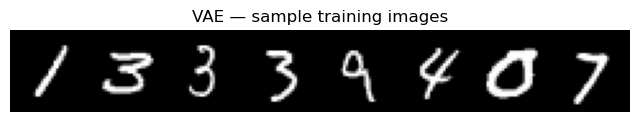

In [8]:
# Quick sanity Check
xb, _ = next(iter(train_loader))
xb_vis = inv_normalize(xb[:8].cpu()).clamp(0,1)
grid = make_grid(xb_vis, nrow=8, padding=2)
plt.figure(figsize=(8,2))
plt.axis('off'); plt.title("VAE — sample training images")
plt.imshow(np.transpose(grid.numpy(), (1,2,0)), cmap='gray')
plt.show()

In [10]:
# VAE model
# - Conv encoder → μ, logσ²
# - Reparameterization: z = μ + σ ⊙ ε
# - ConvTranspose decoder → tanh output in [-1,1]

class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(cin, cout, 3, padding=1),
            nn.GroupNorm(8, cout),
            nn.SiLU(),
            nn.Conv2d(cout, cout, 3, padding=1),
            nn.GroupNorm(8, cout),
            nn.SiLU(),
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    """ConvBlock then stride-2 downsample."""
    def __init__(self, cin, cout):
        super().__init__()
        self.block = ConvBlock(cin, cout)
        self.down = nn.Conv2d(cout, cout, kernel_size=2, stride=2)
    def forward(self, x):
        x = self.block(x)
        x = self.down(x)  # /2
        return x

class UpDec(nn.Module):
    """Stride-2 upsample then ConvBlock."""
    def __init__(self, cin, cout):
        super().__init__()
        self.up = nn.ConvTranspose2d(cin, cout, kernel_size=2, stride=2)
        self.block = ConvBlock(cout, cout)
    def forward(self, x):
        x = self.up(x)    # *2
        x = self.block(x)
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder: 28x28 -> 14x14 -> 7x7
        self.enc_in = nn.Conv2d(1, 32, 3, padding=1)
        self.enc_d1 = Down(32, 64)    # -> 14x14
        self.enc_d2 = Down(64, 128)   # -> 7x7
        self.enc_mid = ConvBlock(128, 128)

        # To latent
        self.flat_dim = 128 * 7 * 7
        self.fc_mu     = nn.Linear(self.flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, latent_dim)

        # From latent
        self.fc_z = nn.Linear(latent_dim, self.flat_dim)

        # Decoder: 7x7 -> 14x14 -> 28x28
        self.dec_mid = ConvBlock(128, 128)
        self.dec_u1  = UpDec(128, 64)   # -> 14x14
        self.dec_u0  = UpDec(64, 32)    # -> 28x28
        self.dec_out = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(16, 1, 1),
            nn.Tanh()                   # [-1, 1]
        )

    def encode(self, x):
        h = self.enc_in(x)
        h = self.enc_d1(h)
        h = self.enc_d2(h)
        h = self.enc_mid(h)
        h = h.flatten(1)               # (B, flat_dim)
        mu     = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    @staticmethod
    def reparameterize(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_z(z).view(-1, 128, 7, 7)
        h = self.dec_mid(h)
        h = self.dec_u1(h)
        h = self.dec_u0(h)
        xhat = self.dec_out(h)
        return xhat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        xhat = self.decode(z)
        return xhat, mu, logvar

In [11]:
# VAE losses (reconstruction + KL)
def vae_recon_loss(xhat, x):
    # With inputs/output in [-1,1], L1/L2 hybrid works well (like AE)
    l1 = F.l1_loss(xhat, x)
    l2 = F.mse_loss(xhat, x)
    return 0.5 * l1 + 0.5 * l2, l1.item(), l2.item()

def vae_kl_loss(mu, logvar):
    # KL(N(mu, sigma^2) || N(0,1)) per sample, then mean over batch
    # = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kld = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    return kld.sum(dim=1).mean()

def beta_warmup(epoch_idx, total_warmup_epochs, target_beta):
    """Linear ramp of β from 0 → target_beta over the first 'total_warmup_epochs'."""
    if total_warmup_epochs <= 0:
        return target_beta
    frac = min(1.0, max(0.0, epoch_idx / float(total_warmup_epochs)))
    return target_beta * frac

In [12]:
# Instantiate & quick shape sanity check
vae = VAE(latent_dim=vcfg.LATENT_DIM).to(device)
print("VAE params (M):", sum(p.numel() for p in vae.parameters())/1e6)

vae.eval()
xb, _ = next(iter(train_loader))
xb = xb.to(device)[:8]
with torch.no_grad():
    xhat, mu, logvar = vae(xb)
print("Input  :", tuple(xb.shape))
print("Output :", tuple(xhat.shape))
print("mu/logvar:", tuple(mu.shape), tuple(logvar.shape))
assert xhat.shape == xb.shape, "Decoder must reconstruct to (N,1,28,28)"
assert mu.shape[-1] == vcfg.LATENT_DIM and logvar.shape[-1] == vcfg.LATENT_DIM

VAE params (M): 1.698305
Input  : (8, 1, 28, 28)
Output : (8, 1, 28, 28)
mu/logvar: (8, 32) (8, 32)


/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_15737/2058241223.py:31: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(self.images[idx], mode="L")


In [13]:
# Training
# - Loss: recon + β * KL  (β is linearly warmed up over first K epochs)
# - Early stopping on **validation total loss**
# - Saves:
#     - `best_model.pt`  (weights only)
#     - `best_val.ckpt`  (full checkpoint with optimizer state)
#     - `last.ckpt`      (final state)
#     - `history.json`   (curves for plotting)

# Optimizer / scheduler / scaler
optimizer = torch.optim.AdamW(vae.parameters(), lr=vcfg.LR, weight_decay=vcfg.WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=max(5, vcfg.EPOCHS), T_mult=1)
scaler = torch.cuda.amp.GradScaler(enabled=vcfg.AMP)

best_path_weights = vae_exp_dir / "best_model.pt"
best_path_ckpt    = vae_exp_dir / "best_val.ckpt"
last_path_ckpt    = vae_exp_dir / "last.ckpt"

def save_ckpt(path, model, optimizer, epoch, metrics: dict):
    torch.save({
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "metrics": metrics,
        "cfg": vars(vcfg),
    }, path)

/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_15737/1385129466.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=vcfg.AMP)


In [14]:
# Train loop with β-warmup + early stopping
best_val = float("inf")
no_improve = 0
history = {"train_total": [], "train_recon": [], "train_kl": [],
           "val_total": [], "val_recon": [], "val_kl": [], "beta": []}

for epoch in range(1, vcfg.EPOCHS + 1):
    beta = beta_warmup(epoch_idx=epoch-1,
                       total_warmup_epochs=vcfg.KL_WARMUP_EPOCHS,
                       target_beta=vcfg.BETA)

    # ---- Train ----
    vae.train()
    t_recon_vals, t_kl_vals, t_tot_vals = [], [], []
    for xb, _ in train_loader:
        xb = xb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=vcfg.AMP):
            xhat, mu, logvar = vae(xb)
            recon, _, _ = vae_recon_loss(xhat, xb)
            kl = vae_kl_loss(mu, logvar)
            loss = recon + beta * kl
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        t_recon_vals.append(recon.item())
        t_kl_vals.append(kl.item())
        t_tot_vals.append(loss.item())
    scheduler.step(epoch)

    # ---- Validate ----
    vae.eval()
    v_recon_vals, v_kl_vals, v_tot_vals = [], [], []
    with torch.no_grad():
        for xb, _ in val_loader:
            xb = xb.to(device)
            xhat, mu, logvar = vae(xb)
            recon, _, _ = vae_recon_loss(xhat, xb)
            kl = vae_kl_loss(mu, logvar)
            total = recon + beta * kl
            v_recon_vals.append(recon.item())
            v_kl_vals.append(kl.item())
            v_tot_vals.append(total.item())

    train_recon = float(np.mean(t_recon_vals)) if t_recon_vals else float("inf")
    train_kl    = float(np.mean(t_kl_vals))    if t_kl_vals    else float("inf")
    train_total = float(np.mean(t_tot_vals))   if t_tot_vals   else float("inf")
    val_recon   = float(np.mean(v_recon_vals)) if v_recon_vals else float("inf")
    val_kl      = float(np.mean(v_kl_vals))    if v_kl_vals    else float("inf")
    val_total   = float(np.mean(v_tot_vals))   if v_tot_vals   else float("inf")

    history["train_total"].append(train_total)
    history["train_recon"].append(train_recon)
    history["train_kl"].append(train_kl)
    history["val_total"].append(val_total)
    history["val_recon"].append(val_recon)
    history["val_kl"].append(val_kl)
    history["beta"].append(beta)

    print(f"Epoch {epoch:03d} | β {beta:.3f} | "
          f"train total {train_total:.5f} (rec {train_recon:.5f}, kl {train_kl:.5f}) | "
          f"val total {val_total:.5f} (rec {val_recon:.5f}, kl {val_kl:.5f})")

    # ---- Early stopping & best checkpoint (minimize val_total) ----
    if best_val - val_total > vcfg.MIN_DELTA:
        best_val = val_total
        no_improve = 0
        save_ckpt(best_path_ckpt, vae, optimizer, epoch,
                  {"val_total": val_total, "val_recon": val_recon, "val_kl": val_kl, "beta": beta})
        torch.save(vae.state_dict(), best_path_weights)
    else:
        no_improve += 1
        if no_improve >= vcfg.PATIENCE:
            print("Early stopping.")
            break

# Save last & history
save_ckpt(last_path_ckpt, vae, optimizer, epoch, {"val_total": val_total, "beta": beta})
with open(vae_exp_dir / "history.json", "w") as f:
    json.dump(history, f, indent=2)

# Load best weights for downstream eval
vae.load_state_dict(torch.load(best_path_weights, map_location=device))
vae.eval()
print("Loaded best weights from:", best_path_weights.resolve())

/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_15737/2058241223.py:31: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(self.images[idx], mode="L")
/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_15737/2498209766.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=vcfg.AMP):


Epoch 001 | β 0.000 | train total 0.23299 (rec 0.23299, kl 1207.76045) | val total 0.11301 (rec 0.11301, kl 814.46971)
Epoch 002 | β 0.333 | train total 4.54391 (rec 0.28384, kl 12.78022) | val total 0.29458 (rec 0.27600, kl 0.05575)
Epoch 003 | β 0.667 | train total 0.29288 (rec 0.27491, kl 0.02695) | val total 0.28278 (rec 0.27357, kl 0.01381)
Epoch 004 | β 1.000 | train total 0.28479 (rec 0.27412, kl 0.01067) | val total 0.27956 (rec 0.27372, kl 0.00584)
Early stopping.
Loaded best weights from: /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/vae_20250925_021453/best_model.pt


/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_15737/2498209766.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(best_path_wei

In [15]:
# Evaluation
# - Test metrics: reconstruction, KL, total (= recon + β·KL), plus Relative L1 / L2

# Ensure best weights are loaded
try:
    best_path_weights
except NameError:
    best_path_weights = vae_exp_dir / "best_model.pt"

vae.load_state_dict(torch.load(best_path_weights, map_location=device))
vae.eval()
print("Loaded best:", best_path_weights.resolve())

Loaded best: /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/vae_20250925_021453/best_model.pt


/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_15737/2143385601.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(best_path_wei

In [16]:
# Test metrics: recon, KL, total (= recon + β·KL), and Relative L1/L2
import json

def per_sample_rel_errors(xhat, x, eps=1e-12):
    diff = (xhat - x)
    relL1 = diff.abs().flatten(1).sum(1) / (x.abs().flatten(1).sum(1) + eps)
    relL2 = torch.sqrt((diff**2).flatten(1).sum(1)) / (torch.sqrt((x**2).flatten(1).sum(1) + eps))
    return relL1, relL2

beta_eval = vcfg.BETA  # evaluation uses the target β (no warmup)

recon_vals, kl_vals, total_vals = [], [], []
relL1_vals, relL2_vals = [], []

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        xhat, mu, logvar = vae(xb)
        # losses
        l_recon, _, _ = vae_recon_loss(xhat, xb)
        l_kl = vae_kl_loss(mu, logvar)
        l_total = l_recon + beta_eval * l_kl
        # relative errors
        r1, r2 = per_sample_rel_errors(xhat, xb)

        recon_vals.append(l_recon.item())
        kl_vals.append(l_kl.item())
        total_vals.append(l_total.item())
        relL1_vals.append(r1.cpu())
        relL2_vals.append(r2.cpu())

recon_mean  = float(np.mean(recon_vals))
kl_mean     = float(np.mean(kl_vals))
total_mean  = float(np.mean(total_vals))
relL1_mean  = torch.cat(relL1_vals).mean().item()
relL2_mean  = torch.cat(relL2_vals).mean().item()

print(f"[TEST] recon: {recon_mean:.6f} | KL: {kl_mean:.6f} | total: {total_mean:.6f} (β={beta_eval})")
print(f"[TEST] Relative L1: {relL1_mean:.6f} | Relative L2: {relL2_mean:.6f}")

with open(vae_exp_dir / "test_metrics.json", "w") as f:
    json.dump({
        "beta": beta_eval,
        "recon": recon_mean, "kl": kl_mean, "total": total_mean,
        "relL1": relL1_mean, "relL2": relL2_mean
    }, f, indent=2)
print("Saved metrics to:", (vae_exp_dir / "test_metrics.json").resolve())

/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_15737/2058241223.py:31: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(self.images[idx], mode="L")


[TEST] recon: 0.111535 | KL: 810.255528 | total: 810.367064 (β=1.0)
[TEST] Relative L1: 0.124452 | Relative L2: 0.325637
Saved metrics to: /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/vae_20250925_021453/test_metrics.json


/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_15737/2058241223.py:31: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(self.images[idx], mode="L")


Indices → BEST: 1295 | MEDIAN: 5380 | WORST: 1782


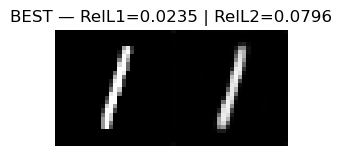

Saved best pair to: /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/vae_20250925_021453/vae_test_best_pair.png


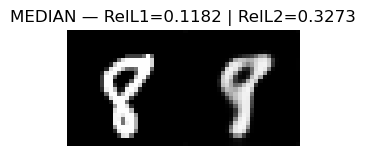

Saved median pair to: /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/vae_20250925_021453/vae_test_median_pair.png


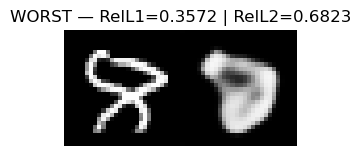

Saved worst pair to: /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/vae_20250925_021453/vae_test_worst_pair.png


In [17]:
# Visualize worst / median / best reconstructions by Relative L2
import matplotlib.pyplot as plt

# accumulate all test images/recons & their errors for ranking
images, recons, errs = [], [], []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        xhat, _, _ = vae(xb)
        _, r2 = per_sample_rel_errors(xhat, xb)
        images.append(xb.cpu()); recons.append(xhat.cpu()); errs.append(r2.cpu())

images = torch.cat(images)   # (N,1,28,28)
recons = torch.cat(recons)
errs   = torch.cat(errs)

worst_idx  = torch.argmax(errs).item()
best_idx   = torch.argmin(errs).item()
median_val = torch.median(errs).item()
median_idx = (errs - median_val).abs().argmin().item()
print("Indices → BEST:", best_idx, "| MEDIAN:", median_idx, "| WORST:", worst_idx)

def show_pair(orig, recon, title, save_path=None):
    o = inv_normalize(orig).clamp(0,1).squeeze(0)   # (H,W)
    r = inv_normalize(recon).clamp(0,1).squeeze(0)  # (H,W)
    both = torch.cat([o, r], dim=-1)
    plt.figure(figsize=(3,3))
    plt.axis('off'); plt.title(title)
    plt.imshow(both, cmap='gray')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=160)
    plt.show()

with torch.no_grad():
    for label, idx in [("BEST", best_idx), ("MEDIAN", median_idx), ("WORST", worst_idx)]:
        x  = images[idx:idx+1]
        xr = recons[idx:idx+1]
        r1, r2 = per_sample_rel_errors(xr, x)
        fp = vae_exp_dir / f"vae_test_{label.lower()}_pair.png"
        show_pair(x[0], xr[0], f"{label} — RelL1={r1.item():.4f} | RelL2={r2.item():.4f}", fp)
        print(f"Saved {label.lower()} pair to:", fp.resolve())

In [ ]:
# Samples from the prior z ~ N(0, I)
from torchvision.utils import make_grid

vae.eval()
n = 64  # 8x8 grid
with torch.no_grad():
    z = torch.randn(n, vcfg.LATENT_DIM, device=device)
    samples = vae.decode(z).cpu()                 # in [-1,1]
    samples_vis = inv_normalize(samples).clamp(0,1)

grid = make_grid(samples_vis, nrow=8, padding=2)
plt.figure(figsize=(6,6))
plt.axis('off'); plt.title("VAE samples — prior z ~ N(0, I)")
plt.imshow(np.transpose(grid.numpy(), (1,2,0)), cmap='gray')
plt.show()

fp = vae_exp_dir / "vae_samples_prior.png"
plt.imsave(fp, np.transpose(grid.numpy(), (1,2,0)))
print("Saved prior samples grid to:", fp.resolve())